In [1]:
import numpy as np
import cfgrib
import xarray as xr
import cartopy.crs as ccrs
from cartopy.crs import Globe
import shapely.geometry as sgeom
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# FILENAME = '/Users/JackKelly/data/weather_forecasts/UKV/2019/08/29/201908290000_u1096_ng_umqv_Wholesale1.grib'
FILENAME = '/Users/JackKelly/data/weather_forecasts/UKV/2017/01/06/201701060600_u1096_ng_umqv_Wholesale1.grib'
# FILENAME = '/Users/JackKelly/data/weather_forecasts/UKV/2015/06/01/prodm_op_ukv_20150601_03_000.pp'

In [3]:
%%time
ds = cfgrib.open_dataset(
    FILENAME,
    # Wind direction and wind speed are the only variables which are at 
    # 10 meters above ground in the UKV GRIB files.
    backend_kwargs={'filter_by_keys': {'level': 10}}
)

# Check this dataset only contains wind speed and wind direction
assert 'si10' in ds
assert 'wdir10' in ds
assert len(ds) == 2

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


CPU times: user 57.3 ms, sys: 27.7 ms, total: 85 ms
Wall time: 369 ms


In [4]:
ds

<xarray.Dataset>
Dimensions:            (step: 37, values: 385792)
Coordinates:
    time               datetime64[ns] ...
  * step               (step) timedelta64[ns] 00:00:00 ... 1 days 12:00:00
    heightAboveGround  int64 ...
    valid_time         (step) datetime64[ns] ...
Dimensions without coordinates: values
Data variables:
    si10               (step, values) float32 ...
    wdir10             (step, values) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             U.K. Met Office - Exeter
    history:                 2019-09-13T10:52:41 GRIB to CDM+CF via cfgrib-0....

Variable names in wholesale1
* r = relative humidity
* t = temperature
* dpt = dew point temperature
* vis = visability
* si10 = 10 metre wind speed, m/s
* wdir10 = 10 metre wind direction, Degree true
* prmsl = Pressure reduced to MSL
* prate = Precipitation rate

In [5]:
KM_TO_M = 1000

NORTH = 1223 * KM_TO_M
SOUTH = -185 * KM_TO_M
WEST = -239 * KM_TO_M
EAST = 857 * KM_TO_M

DY = DX = 2 * KM_TO_M

In [6]:
%%time
NORTHING = np.arange(start=SOUTH, stop=NORTH, step=DY, dtype=np.int32)
EASTING = np.arange(start=WEST, stop=EAST, step=DX, dtype=np.int32)

NUM_ROWS = len(NORTHING)
NUM_COLS = len(EASTING)


def reshape_data(data: xr.DataArray) -> xr.DataArray:   
    # The UKV data is of shape <num_time_steps, num_values> and we want
    # it in shape <num_time_steps, <num_rows>, <num_columns>
    num_time_steps = len(data['step'])
    reshaped = data.values.reshape((num_time_steps, NUM_ROWS, NUM_COLS))
    
    # The data in the GRIB file starts from the bottom left:
    # 6 7 8
    # 3 4 5
    # 0 1 2
    # Reverse the order of the rows, so the image starts from the top left corner:
    # 0 1 2 
    # 3 4 5
    # 6 7 8
    reshaped = reshaped[:, ::-1, :]
    
    # Get new coords
    coords = data.expand_dims(
        {
            'northing': NORTHING,
            'easting': EASTING
        },
        axis=[1, 2]
    ).coords

    # AFAICT, we Xarray doesn't allow us to re-shape data in-place.  Instead,
    # we create a new DataArray with the reshaped data, and the same name & attrs
    # as the source DataArray.
    return xr.DataArray(
        reshaped,
        dims=['step', 'northing', 'easting'],
        coords=coords,
        name=data.name,
        attrs=data.attrs
    )

CPU times: user 30 µs, sys: 19 µs, total: 49 µs
Wall time: 42 µs


In [7]:
%%time
# Reshape all the DataArrays in the DataSet
new_dataset_dict = {}
for name in ds:
    new_dataset_dict[name] = reshape_data(ds[name])
new_dataset = xr.Dataset(new_dataset_dict)

CPU times: user 1.6 s, sys: 116 ms, total: 1.72 s
Wall time: 1.73 s


In [8]:
class UKVDomain(ccrs.OSGB):
    """The geographical domain of the UK Met Office UKV model."""
    
    @property
    def x_limits(self):
        return (WEST, EAST)
    
    @property
    def y_limits(self):
        return (SOUTH, NORTH)
    
    @property
    def boundary(self):
        return sgeom.LineString([
            (WEST, SOUTH), 
            (WEST, NORTH), 
            (EAST, NORTH), 
            (EAST, SOUTH), 
            (WEST, SOUTH)])

In [9]:
# For testing, get points for several locations within UKV
locations_geodetic = pd.DataFrame(
    {
        'skaw': (60.8222375, -0.805741),  # Skaw is in the north Shetlands
        'london': (51.5286416, -0.1015987),
        'dublin': (53.3244431, -6.3857855),
    },
    index=['lat', 'lon']
).T

locations_geodetic.index.name = 'location_name'
locations_geodetic

,lat,lon
location_name,,
skaw,60.822237,-0.805741
london,51.528642,-0.101599
dublin,53.324443,-6.385785


## Get four nearest points

In [10]:
def _floor(array):
    return np.floor(array).astype(np.int32)


def _ceil(array):
    return np.ceil(array).astype(np.int32)


def search_two_nearest(array, query):
    """
    Returns:
        floor, ceiling:  Values from array, where query lies between floor and ceiling.
    """
    idx = np.searchsorted(array, query)
    idxs = [idx-1, idx]
    idxs = np.clip(
        idxs, 
        a_min=0, 
        a_max=len(array)-1)
    return array[idxs]


def nearest_points(x, y, src_crs, dst_crs):
    points = dst_crs.transform_points(src_crs=src_crs, x=x.values, y=y.values)[:, :-1]
    new_x = points[:, 0]
    new_y = points[:, 1]

    floor_x, ceil_x = search_two_nearest(EASTING, new_x)
    floor_y, ceil_y = search_two_nearest(NORTHING, new_y)

    corners = {
        'nw': np.stack((floor_x, ceil_y)),
        'ne': np.stack((ceil_x, ceil_y)),
        'se': np.stack((ceil_x, floor_y)),
        'sw': np.stack((floor_x, floor_y))
    }
    
    dfs = []
    for corner, coordinates in corners.items():
        df = pd.DataFrame(
            coordinates.T, 
            columns=['easting', 'northing'], 
            index=x.index)
        df.index.name = x.index.name 
        df['corner'] = corner
        dfs.append(df)
    
    return pd.concat(dfs).sort_index()

In [11]:
# Convert lat/lons to UKVDomain
locations_osng = nearest_points(
    x=locations_geodetic['lon'],
    y=locations_geodetic['lat'],
    src_crs=ccrs.Geodetic(),
    dst_crs=UKVDomain())

In [12]:
locations_osng

,easting,northing,corner
location_name,,,
dublin,107000,391000,nw
dublin,109000,391000,ne
dublin,109000,389000,se
dublin,107000,389000,sw
london,531000,183000,nw
london,533000,183000,ne
london,533000,181000,se
london,531000,181000,sw
skaw,465000,1217000,nw


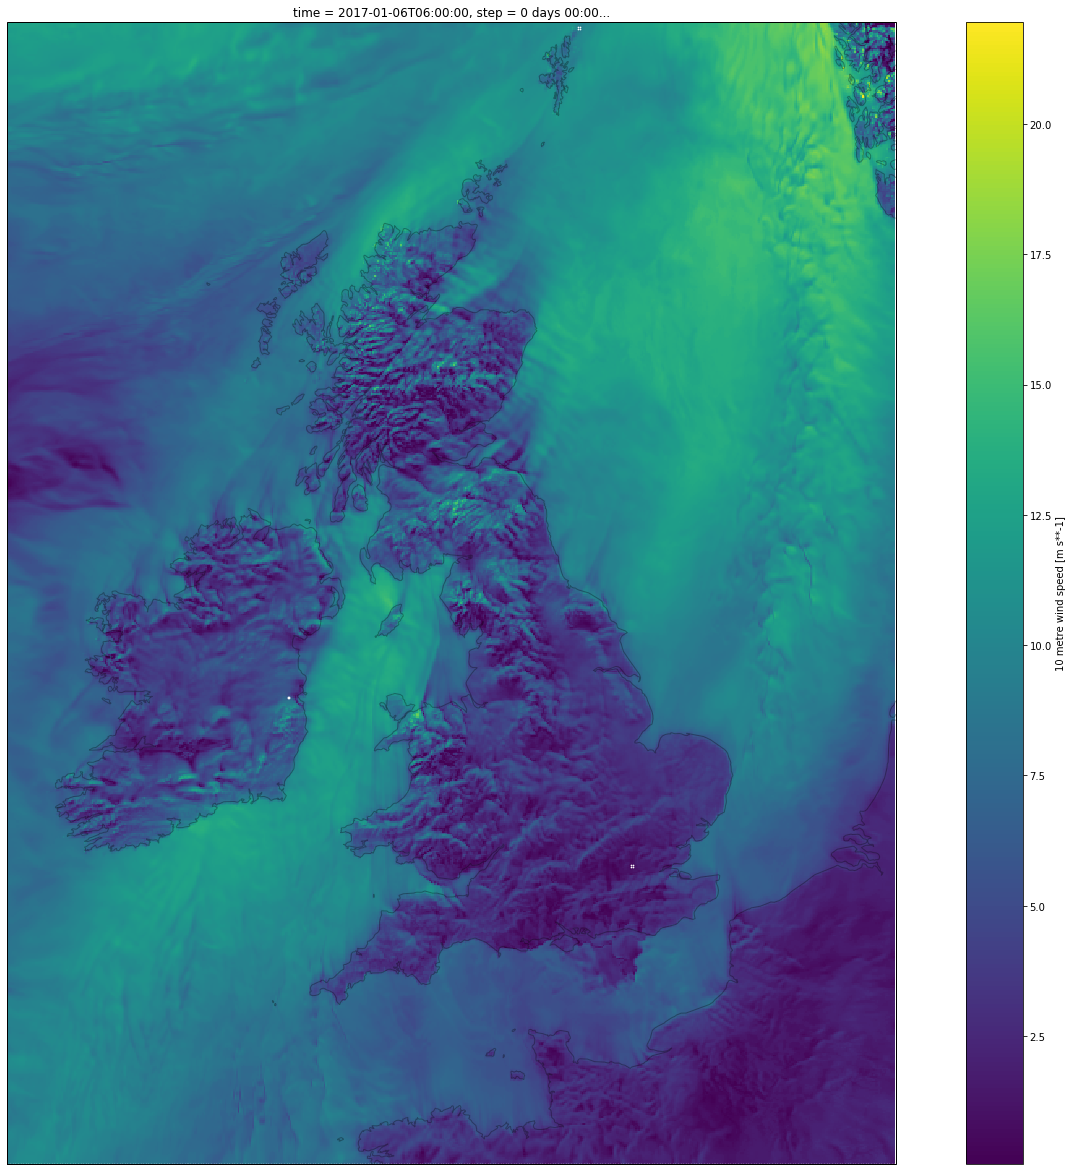

In [13]:
fig = plt.figure(figsize=(25, 21))
ax = plt.axes(projection=UKVDomain())

# Plot wind speed
new_dataset.isel(step=0)['si10'].plot.pcolormesh(ax=ax)

# Plot locations
ax.scatter(locations_osng['easting'], locations_osng['northing'], c='white', s=0.5)

ax.set_global()
ax.coastlines(resolution='10m', alpha=0.3);

## Get timeseries of wind speeds and directions for points

In [14]:

winds_for_all_locs = {}

for loc_name in np.unique(locations_osng.index):
    
    grid_points_for_loc = locations_osng.loc[loc_name]
    wind_speed_for_4_grid_points = new_dataset['si10'].sel(
        easting=grid_points_for_loc['easting'].values, 
        northing=grid_points_for_loc['northing'].values
    )
    
    winds = []
    for corner_i, corner_name in enumerate(grid_points_for_loc['corner']):
        
        wind_speed = pd.DataFrame(
            wind_speed_for_4_grid_points[:, corner_i, corner_i].values,
            columns=['wind_speed_mps'],
            index=wind_speed_for_4_grid_points['valid_time'].values
        )
        wind_speed['corner'] = corner_name
        wind_speed['forecast_hour'] = wind_speed_for_4_grid_points['step'].values
        winds.append(wind_speed)
    
    winds_for_all_locs[loc_name] = pd.concat(winds)

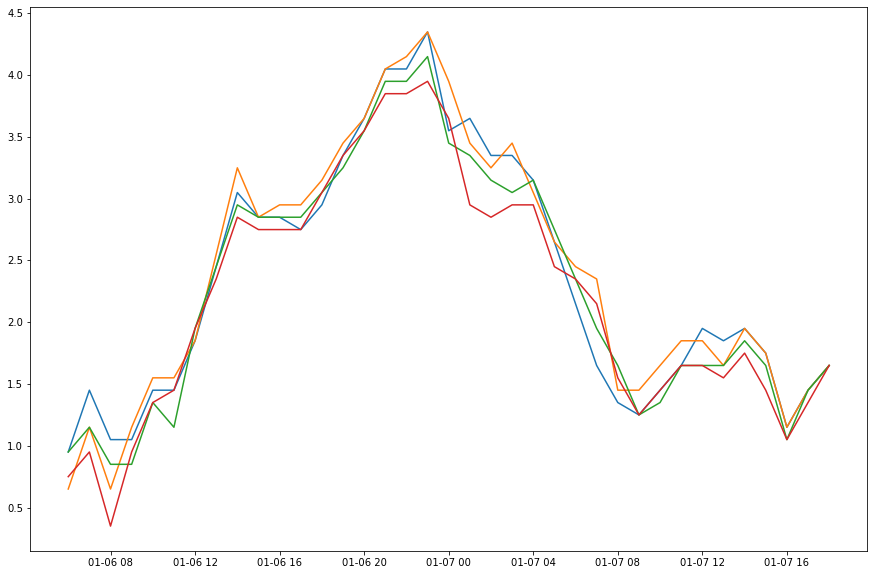

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(
    winds_for_all_locs['london'].pivot_table(
        index=winds_for_all_locs['london'].index,
        columns='corner',
        values='wind_speed_mps'))

In [18]:
winds_for_all_locs['london'].head()

,wind_speed_mps,corner,forecast_hour
2017-01-06 06:00:00,0.65,nw,00:00:00
2017-01-06 07:00:00,1.15,nw,01:00:00
2017-01-06 08:00:00,0.65,nw,02:00:00
2017-01-06 09:00:00,1.15,nw,03:00:00
2017-01-06 10:00:00,1.55,nw,04:00:00
